# Laborator 6 - Segmentare Semantica

In acesti laborator veti implementa si antrena o retea complet convolutionala ([U-Net](https://arxiv.org/pdf/1505.04597.pdf)), al carei rezultat este o imagine (nu doar clasificare). Veti implementa 2 blocuri (downsampling si upsampling), skip connections si antrenarea retelei pentru a clasifica fiecare pixel din imagine.

Veti construi o retea de segmentare semantica pentru a identifica spatiul liber pe drum (veti folosi setul de date [Kitti Road](http://www.cvlibs.net/datasets/kitti/eval_road.php)).

## De ce U-Net?

O retea convolutionala normala consta dintr-o serie de straturi convolutionale, urmata de straturi fully connected si, in cele din urma, de o functie de activare Softmax. aceasta este o arhitectura buna pentru clasificare, insa straturile fully connected nu pastreaza informatia spatiala. U-Net pastreaza informatia spatiala in intreaga retea (U-Net functioneaza cu imagini de orice dimensiune).

Din punct de vedere structural, U-Net este compusa din doua parti: encoder (blocuri de downsampling) si decoder (blocuri de upsampling; mareste outputul encoderului pentru a fi de aceeasi dimensiune ca imaginea originala; astfel, se realizeaza clasificarea fiecarui pixel individual din imaginea originala)

---

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
!mkdir ./data ./runs ./saved_models
# Download and unzip the dataset
!wget --progress=bar:force https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip -P ./data
!unzip ./data/data_road.zip -d ./data

--2020-05-03 10:57:17--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.73.64
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.73.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘./data/data_road.zip’

data_road.zip       100%[===================>] 449.17M  10.3MB/s    in 46s     

2020-05-03 10:58:04 (9.67 MB/s) - ‘./data/data_road.zip’ saved [470992343/470992343]

Archive:  ./data/data_road.zip
   creating: ./data/data_road/
   creating: ./data/data_road/training/
   creating: ./data/data_road/testing/
   creating: ./data/data_road/training/image_2/
  inflating: ./data/data_road/training/image_2/umm_000032.png  
  inflating: ./data/data_road/training/image_2/umm_000031.png  
  inflating: ./data/data_road/training/image_2/umm_000030.png  
  inflating: ./data/data_road/training/image

# Pregatirea setului de date

In celula de mai jos sunt implementate clasele torch.utils.data.Dataset ce vor fi folosite pentru a itera prin seturile de date de antrenare si de test din Kitti Road Segmentation. 

De asemenea sunt implementate doua *collate_fn()* una pentru antrenare ce returneaza si imagini si adnotari, si una pentru testare ce returneaza doar imagini.

In final sunt instantiate 3 obiecte torch.utils.data.DataLoader: unul pentru antrenare, unul pentru testare si unul pentru vizualizare.

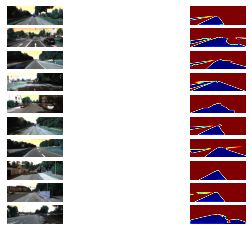

In [0]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import normalize, to_tensor

%matplotlib inline

# Initializare de constante ce contin caile pana la seturile de date de 
# antrenare si de testare.
TRAIN_IMAGES_PATH = "./data/data_road/training/image_2"
TRAIN_LABELS_PATH = "./data/data_road/training/gt_image_2"
TEST_IMAGES_PATH = "./data/data_road/testing/image_2"


def collate_fn_train(examples) -> tuple:
  """ Functie ce pre-proceseaza datele de antrenare.

  """
  images = []
  labels = []
  for example in examples:
    image, label = example
    # Transformam imaginea in torch.Tensor
    image = to_tensor(image)
    # Normalizam imaginea in [-1, 1]
    image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # Adaugam dimenziunea mini-batch-ului la imagine
    image = image.unsqueeze(0)
    # Transformam adnotarea in tensor si adaugam dimensiunea mini-batch-ului
    # la adnotare
    label = torch.tensor(label).unsqueeze(0)
    images.append(image)
    labels.append(label)
  
  # Concatenam imaginile intr-un mini-batch
  images_batch = torch.cat(images)
  # Concatenam adnotarile intr-un mini-batch
  labels_batch = torch.cat(labels)

  return images_batch, labels_batch

def collate_fn_test(examples) -> torch.Tensor:
  """functie ce preproceseaza datele de testare

  """
  images = []
  for example in examples:
    image = example
    image = to_tensor(image)
    image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    image = image.unsqueeze(0)
    images.append(image)

  images_batch = torch.cat(images)

  return images_batch

class KittiImageDataset(Dataset):
  """Clasa ce mosteneste din torch.utils.data.Dataset si implementeaza un set de
  date ce contine doar imagini.
  """
  def __init__(self, images_root, original_shape=(1242, 375) ,
               load_shape=(384, 128)):
    """Constructor care citeste path-urile catre imaginile de test.

    Args:
      images_root: Calea catre directorul ce contine imaginile
      original_shape: Dimensiunea imaginilor din setul de date
      load_shape: Dimensiunea imaginilor ce trebuiesc returnate din setul de date
    """
    # Apelam constructorul din superclasa
    super(KittiImageDataset, self).__init__()
    self.images_root = images_root
    self.original_shape = original_shape
    self.load_shape = load_shape
    self.images = list(sorted(glob.glob(os.path.join(TRAIN_IMAGES_PATH ,'*'))))

  def __getitem__(self, idx) -> np.ndarray:
    """Metoda ce face override la metoda __getitem__(). Folosing indexul primit,
      idx, se returneaza o imagine din setul de date.

    Args:
      idx: Indexul imaginii ce trebuie returnata

    Returns:
      np.ndarray

    """
    # Citim imaginea
    image = cv2.imread(self.images[idx])
    # Redimensionam imaginea la
    image = cv2.resize(image, self.load_shape)

    return image

  def __len__(self) -> int:
    """Metoda ce face override la metoda __len__(). Intoare numerul de imagini
      din setul de date.

    Returns:
      int
    """
    return len(self.images)

class KittiTrainDataset(KittiImageDataset):
  """Clasa ce mosteneste din KittiImageDataset si implementeaza un set de
  date ce contine imagini si adnotari pentru antrenare.
  """
  def __init__(self, images_root, labels_root, original_shape=(1242, 375) ,
               load_shape=(384, 128)):
    """Constructor care citeste path-urile catre imaginile si adnotarile de 
      antrenare.

    Args:
      images_root: Calea catre directorul ce contine imaginile
      labels_root: Calea catre directorul ce contine adnotarile
      original_shape: Dimensiunea imaginilor din setul de date
      load_shape: Dimensiunea imaginilor ce trebuiesc returnate din setul de date
    """
    # Apelam constructorul din superlcasa
    super(KittiTrainDataset, self).__init__(images_root, original_shape=original_shape, 
                                            load_shape=load_shape)
    # Adaugam atributele noi
    self.labels_root = labels_root
    self.labels = list(sorted(glob.glob(os.path.join(TRAIN_LABELS_PATH, '*_road_*'))))

  def __getitem__(self, idx) -> tuple:
    """Metoda ce face override la metoda __getitem__(). Folosing indexul primit,
      idx, se returneaza o imagine si o adnotare din setul de date.

    Args:
      idx: Indexul imaginii ce trebuie returnata

    Returns:
      tuple(np.ndarray, np.ndarray)

    """
    # Apelam functia __getitem__ din super clasa
    image = super(KittiTrainDataset, self).__getitem__(idx)
    # Procesam si adnotarile
    label = cv2.imread(self.labels[idx])
    label = cv2.resize(label, self.load_shape, interpolation=cv2.INTER_NEAREST)
    new_label = label.sum(axis=2)
    new_label = np.where(new_label == 255, 1, 0)
    
    return image, new_label

  def __len__(self) -> int:
    assert len(self.images) == len(self.labels)
    return len(self.images)


train_dataset = KittiTrainDataset(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)
test_dataset = KittiImageDataset(TEST_IMAGES_PATH)
vis_dataloader = DataLoader(train_dataset, shuffle=True)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, 
                              num_workers=2, collate_fn=collate_fn_train)
test_dataloader = DataLoader(test_dataset, shuffle=True, collate_fn=collate_fn_test)


# Cod de vizualizare
num_samples = 10
vis_iter = iter(vis_dataloader)
for i in range(num_samples):

  image, label = vis_iter.next()
  image = image.squeeze(0).numpy()
  label = label.squeeze(0).numpy()
  plt.subplot(num_samples, 2, 2*i+1)
  plt.axis('off')
  plt.imshow(image, None)
  plt.subplot(num_samples, 2, 2*i+2)
  plt.axis('off')
  plt.imshow(label[:,:], 'jet')

# Implementarea Retelei U-Net

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In celula urmatoare se gaseste codul partial pentru implementarea retelei U-Net. Implementam 4 clase ce reprezinta straturi de downsampling, straturi de upsampling si blocuri convolutionale de downsampling si upsampling din arhitectura U-Net ce se regaseste in imaginea de mai sus.

Arhitectura contine:
 * un encoder cu 4 blocuri convolutionale de downsampling
 * un decoder cu 4 blocuri convolutionale de upsampling
 * skip connections intre blocurile de downsampling si upsampling

## Ceinte

 1. Implementati clasa ConvBNRelu ce trebuie sa contina urmatoarele straturi in aceasta ordine:
    * o convolutie 2D cu filtru de dimensiune 3x3, stride 1 si padding 1
    * un strat batchnorm
    * o functie de activate ReLU

 2. Implementati clasa DownBlock ce reprezinta un bloc de downsampling din encoderul U-Net si contine 2 straturi convolutionale (folositi ConvBNRelu) si un strat MaxPool2d cu filtru de dimensiune 2x2 si stride 2
    * **Atentie!** Returnati iesirea stratului de pooling si iesirea stratului de dinaintea stratului de pooling. Cel din urma va fi folosit in skip connections.

 3. Implementati clasa ConvTransposeBNRelu ce trebuie sa contina urmatoarele straturi in aceasta ordine:
    * o convolutie transpusa 2D cu filtru de dimensiune 2x2 si stride 2
    * un strat batchnorm
    * o functie de activate ReLU
    * **Hint!** Folosim filtru de dimensiune 2x2 si stride 2 pentru convolutia transpusa deoarece arhitectura trebuie sa fie simetrica (encoder vs decoder) pentru a returna o imagine de aceleasi dimensiuni ca inputul

 4. Implementati clasa UpBlock - similar cu DownBlock, dar returnam doar outputul final

 5. In pasul de forward din reteaua U-Net implementati skip connection folosind concatenare


 **Hint:** 
  * folositi imaginea arhitecturii pentru a va ajuta in implementare
  * considereati adancimea stratului din mijloc din blocul din partea inferioara a figurii 512 in loc de 1024

In [0]:
import torch
import torch.nn as nn


class ConvBNRelu(nn.Module):
  """Clasa ce mosteneste din torch.nn.Module si implementeaza un bloc 
    convolutional cu conv2d + batchnorm + ReLU"""
  def __init__(self, in_channels:int, out_channels:int):
    """Constructor

    Args:
      in_channels: Numarul de canale de intrare in bloc
      out_channels: Numarul de canale de iesire din bloc
    """
    super(ConvBNRelu, self).__init__()

       # Your code here
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = 1, padding = 1))
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU())

    self.conv_bn_relu = nn.Sequential(*layers)


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """Metoda ca face override la metoda forward() pentru pasul de forward
      propagation.

      Args:
        x: Tensorul de intrare

      Returns:
        torch.Tensor

    """
       # Your code here
    x = self.conv_bn_relu(x)
    return x



class DownBlock(nn.Module):
  """Clasa ce mosteneste din nn.Module si implementeaza un bloc de 
    downsampling."""
  def __init__(self, in_channels:int, out_channels:int):
    """Constructor

    Args:
      in_channels: Numarul de canale de intrare in bloc
      out_channels: Numarul de canale de iesire din bloc
    """
    super(DownBlock, self).__init__()

       # Your code here
    layers = [ConvBNRelu(in_channels, out_channels), ConvBNRelu(out_channels, out_channels)]
    self.convs = nn.Sequential(*layers)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


  def forward(self, x:torch.Tensor) -> tuple:
    """Metoda ca face override la metoda forward() pentru pasul de forward
      propagation. Se returneaza pe langa outputul final si feature-urile de
      dinainte de downsampling pentru implementarea skip connections din U-Net.

      Args:
        x: Tensorul de intrare

      Returns:
        tuple(torch.Tensor, torch.Tensor)

    """
       # Your code here
    feats = self.convs(x)
    x_down = self.pool(feats)

    return x_down, feats



class ConvTransposeBNRelu(nn.Module):
  """Clasa ce mosteneste din torch.nn.Module si implementeaza un bloc 
    convolutional transpus cu convtranspose2d + batchnorm + ReLU"""
  def __init__(self, in_channels:int, out_channels:int):
    """Constructor

    Args:
      in_channels: Numarul de canale de intrare in bloc
      out_channels: Numarul de canale de iesire din bloc
    """
    super(ConvTransposeBNRelu, self).__init__()

       # Your code here
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride = 2))
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU())

    self.convtranspose_bn_relu = nn.Sequential(*layers)


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """Metoda ca face override la metoda forward() pentru pasul de forward
      propagation.

      Args:
        x: Tensorul de intrare

      Returns:
        torch.Tensor

    """
       # Your code here
    return self.convtranspose_bn_relu(x)



class UpBlock(nn.Module):
  """Clasa ce mosteneste din nn.Module si implementeaza un bloc de 
    upsampling."""
  def __init__(self, in_channels:int, out_channels:int):
    """Constructor

    Args:
      in_channels: Numarul de canale de intrare in bloc
      out_channels: Numarul de canale de iesire din bloc
    """
    super(UpBlock, self).__init__()

       # Your code here
    layers = [ConvBNRelu(in_channels, out_channels), ConvBNRelu(out_channels, out_channels), ConvTransposeBNRelu(in_channels, out_channels)]
    self.block = nn.Sequential(*layers)


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """Metoda ca face override la metoda forward() pentru pasul de forward
      propagation.

      Args:
        x: Tensorul de intrare

      Returns:
        torch.Tensor

    """
       # Your code here
    return self.block(x)



class UNet(nn.Module):
  """Clasa ce mostensete din nn.Module si implementeaza arhitectura retelei
    U-Net."""
  def __init__(self, num_classes:int=2, in_channels:int=3, min_depth:int=64, 
               max_depth:int=1024, num_blocks:int=4):
    """Constructor
    
    Args:
      num_classes: Numarul de clase din setul de date
      in_channels: Numarul de canale de intrare
      min_depth: Numarul de canale minim ce poate iesi dintr-un bloc
      max_depth: Numarul de canale maxim ce poate iesi dintr-un bloc
      num_blocks: Numarul de blocuri de downsampling, respectiv upsampling
    """
    super(UNet, self).__init__()

    self.num_classes = num_classes
    self.in_channels = in_channels
    self.min_depth = min_depth
    self.max_depth = max_depth
    self.num_blocks = num_blocks

    # Setam blocurile de downsampling intr-un nn.ModuleList. Folosim 
    # nn.ModuleList in loc de o lista normala, pentru ca Pytorch sa ia in
    # considerare modulele din lista in graful retelei.
    self.encoder = nn.ModuleList()
    for i in range(self.num_blocks):
      if i == 0:
        # Daca este primul strat, atunci numarul de canale de intrare va fi 3
        self.encoder.append(DownBlock(self.in_channels, self.min_depth))
      else:
        # Daca nu este primul strat, numarul de canale este calculat dinamic 
        # intre self.min_depth si self.max_depth
        inch = min(self.min_depth*(2**(i-1)), self.max_depth)
        outch = min(self.min_depth*(2**i), self.max_depth)
        self.encoder.append(DownBlock(inch, outch))

    # Setam blocurile de upsampling intr-un nn.ModuleList.
    self.decoder = nn.ModuleList()
    for i in reversed(range(self.num_blocks)):
      if i == self.num_blocks - 1:
        # Daca este primul strat de upsampling numarul de canale de intrare si
        # numarul de canale de iesire este egal
        inch = min(self.min_depth*(2**i), self.max_depth)
        outch = min(self.min_depth*(2**i), self.max_depth)
        self.decoder.append(UpBlock(inch, outch))
      else:
        # Daca nu este primnul strat de upsampling numarul de canale de intrare
        # si numarul de canale de iesire este calculat dinamic. Numarul de 
        # canale de intrare este dublat pentru a lua in considerare concatenarea
        # din skip connections din arhitectura U-Net.
        inch = 2*min(self.min_depth*(2**(i+1)), self.max_depth)
        outch = min(self.min_depth*(2**i), self.max_depth)
        self.decoder.append(UpBlock(inch, outch))

    # Setam straturile convolutionale de iesire
    self.out_convs = nn.Sequential(
        ConvBNRelu(2*outch, self.min_depth),
        ConvBNRelu(self.min_depth, self.min_depth),
        nn.Conv2d(self.min_depth, self.num_classes, kernel_size=1, stride=1, 
                  padding=0)
    )


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """Metoda ca face override la metoda forward() pentru pasul de forward
      propagation.

      Args:
        x: Tensorul de intrare

      Returns:
        torch.Tensor

    """
    encoder_outputs = []
    # Facem pasul prin encoder
    for i in range(self.num_blocks):
      x, feats = self.encoder[i](x)
      encoder_outputs.append(feats)

    # Facem pasul prin decoder
    for i in range(self.num_blocks):
      x = self.decoder[i](x)
         # Your code here
      x =  torch.cat([encoder_outputs[i], x],1)

    return self.out_convs(x)


unet = UNet().cuda()

# Antrenarea retelei

In [0]:
import torch.optim as optim

num_epochs = 10

# Initializam functia de loss
loss_fn = nn.CrossEntropyLoss()

# Initializam optimizatorul
optimizer = optim.SGD(unet.parameters(), lr=0.001)
optimizer.zero_grad()

# Antrenam reteaua
for epoch in range(num_epochs):
  for idx, (image, label) in enumerate(train_dataloader):
    pred = unet(image.cuda())
    loss = loss_fn(pred, label.cuda())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if idx % 10 == 0:
      print("Epoch {} - Iter {} - Loss {}".format(epoch, idx, loss.item()))

# Rularea retelei pe setul de date de test si vizualizare

## Cerinta
 * Procesati iesirea retelei pentru a vizualiza masca de segmentare prezisa ca in celula pentru pregatirea setului de date.

**Hints**
 * Iesirea va fi un feature map de dimensiunea imaginii de intrare cu 2 canale.
 * Pentru fiecare pixel canalele trebuiesc transformate intr-o distributie de probabilitati (Softmax)
 * Transformati intr-o imagine cu un singur canal cu valori 255 pentru clasa 'road' si 0 pentru clasa 'background'

In [0]:
unet.eval()

num_to_show = 10

softmax = nn.Softmax(dim=1)
# Ne asiguram ca nu se pot propaga gradienti prin retea
with torch.no_grad():
  for idx, image in enumerate(test_dataloader):

    if idx > num_to_show:
      break

    logits = unet(image.cuda())

    # Postprocesarea imaginii pentru a fi vizualizata
    image = image.squeeze(0).clone().cpu().numpy().transpose(1, 2, 0)

         # Your code here
        

    # Cod de vizualizare
    plt.subplot(num_to_show, 2, 2*idx+1)
    plt.axis('off')
    plt.imshow(image, None)
    plt.subplot(num_to_show, 2, 2*idx+2)
    plt.axis('off')
    plt.imshow(pred[:,:], 'jet')



